# Titanic

In [1]:
# load the data
import pandas as pd

#random seed to use
RAND_SEED = 42

df = pd.read_csv('train.csv',index_col='PassengerId')
display(df.info())
display(df.head(10))
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


None

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Text(0,0.5,'Count')

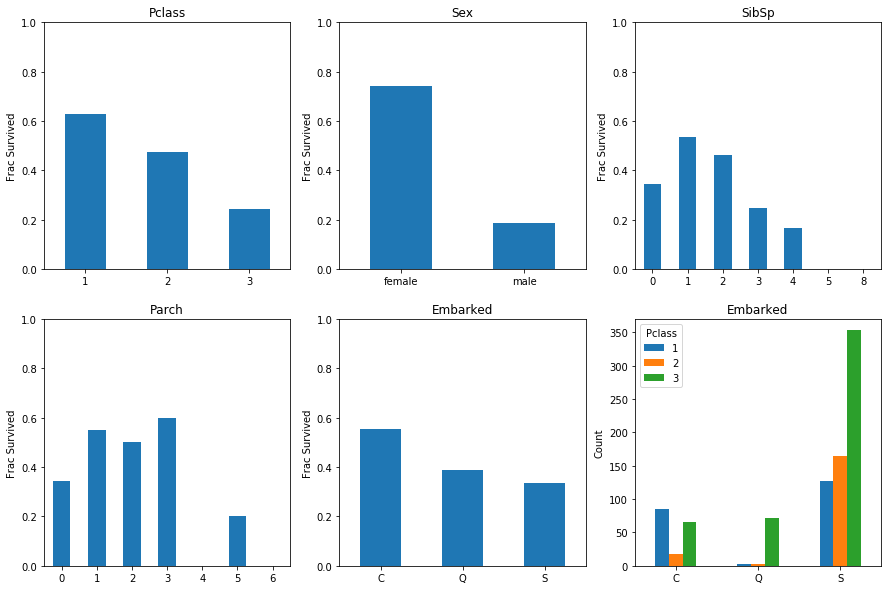

In [2]:
# few bar plots to get an idea of survival rate in some of the categories

import matplotlib.pyplot as plt
%matplotlib inline

def mean_survived(feature,frame):
    return frame.groupby(feature).Survived.mean()

plot_feats = ['Pclass','Sex','SibSp','Parch','Embarked']
plt.figure(figsize=(15,10))
figRows=2
figCols=3
i=1
for feature in plot_feats:
    ax=plt.subplot(2,3,i)
    mean_survived(feature,df).plot.bar(title=feature,ax=ax,rot=0)
    plt.xlabel('')
    plt.ylabel('Frac Survived')
    plt.ylim(0,1)
    i+=1

ax=plt.subplot(2,3,6)
df.groupby('Embarked')['Pclass'].value_counts().unstack().plot.bar(title='Embarked',ax=ax,rot=0)
plt.xlabel('')
plt.ylabel('Count') 

Passengers with shared ticket but no parents,children,siblings or spouse onboard:  75


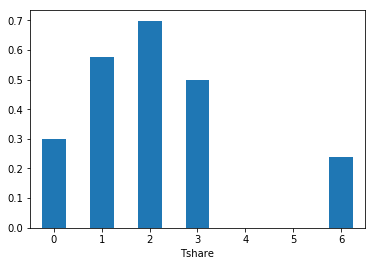

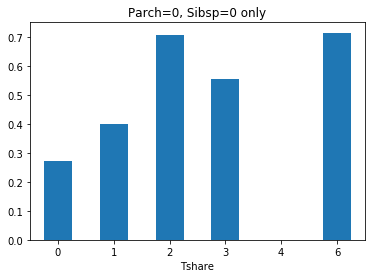

In [3]:
# add a column with number of people the passenger shares a ticket number with. Remove original Ticket column.
def transform_ticket(df):
    Tshare=pd.DataFrame(df.Ticket.value_counts()-1)
    Tshare.columns = ['Tshare']
    df = pd.merge(df,Tshare,how='outer',left_on='Ticket',right_index=True)
    return df.drop('Ticket',axis=1)

df = transform_ticket(df)

print('Passengers with shared ticket but no parents,children,siblings or spouse onboard: ',len(df[(df.Tshare>0) & (df.Parch==0) & (df.SibSp==0)]))
mean_survived('Tshare',df).plot.bar(rot=0)
plt.figure()
df[(df.Parch==0) & (df.SibSp==0)].groupby('Tshare')['Survived'].mean().plot.bar(title='Parch=0, Sibsp=0 only',rot=0)

Unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: Cabin, dtype: int64

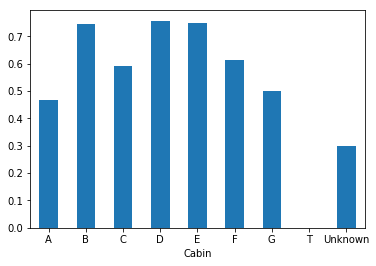

In [4]:
# Only keep first letter in cabin column
import re as re

def transform_cabin(df):
    df.Cabin = df.Cabin.apply(lambda x: re.search('[A-Za-z]+',x).group() if type(x) is str and len(x)>0 else 'Unknown')
    return df

df = transform_cabin(df)

display(df.Cabin.value_counts())
mean_survived('Cabin',df).plot.bar(rot=0)

Mr          517
Miss        186
Mrs         125
Master       40
Dr            7
Rev           6
Nobility      5
Military      5
Name: Title, dtype: int64

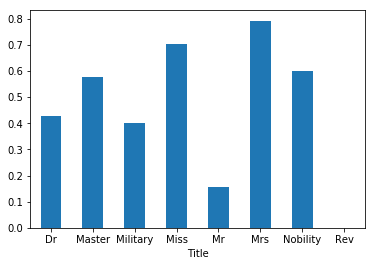

In [5]:
# extract titles from names

def transform_name(df):
    # Title is contained in name with a preceding space followed by a '.'
    df['Title'] = df.Name.apply(lambda name: re.search(' ([A-Za-z]+)\.', name).group(1))

    #display(df.Title.value_counts())
    # Jonkheer, Don and Dona are nobility titles.

    # Group some titles together
    df.Title.replace(['Countess', 'Sir', 'Lady', 'Don', 'Dona', 'Jonkheer'],'Nobility',inplace=True)
    df.Title.replace(['Major', 'Col', 'Capt'],'Military',inplace=True)
    df.Title.replace(['Ms','Mlle','Mme'],'Miss',inplace=True)

    # don't need name column anymore
    return df.drop('Name',axis=1)

df = transform_name(df)

display(df.Title.value_counts())
mean_survived('Title',df).plot.bar(rot=0)

In [6]:
# categorise fares

# basic stats on total ticket fare
print('TICKET TOTAL FARES:')
display(df.groupby('Pclass').Fare.describe())

# calculate fare per person on ticket
df['Farepp'] = df.Fare/(df.Tshare+1)
print('FARES PER PERSON:')
display(df.groupby('Pclass').Farepp.describe())

# quantiles to split fare in to (separately for each class)
quantiles = [0, 1.0/3, 2.0/3, 1]
q_labels = ['q33','q66','q100']

# calculate bin edges for each class
Faretot_bins = dict()
Farepp_bins = dict()

for pclass in df.Pclass.unique():
    # extract passengers in pclass
    p_inclass = df[df.Pclass==pclass]
    
    # calculate quantiles
    tot_edges = p_inclass.Fare.quantile(quantiles).values
    pp_edges = p_inclass.Farepp.quantile(quantiles).values

    # ensure min and max fall in bins
    tot_edges[0] = -1
    tot_edges[-1] = 100*tot_edges[-1]
    pp_edges[0] = -1
    pp_edges[-1] = 100*pp_edges[-1]
    
    # save bin edge values
    Faretot_bins[pclass] = tot_edges    
    Farepp_bins[pclass] = pp_edges

# bin the data frame
def transform_fare(df):
    # if df doesn't have Farepp column, create it
    if not df.columns.contains('Farepp'):
        df['Farepp'] = df.Fare/(df.Tshare+1)
    
    # bin fare in to quantiles for each class
    for pclass in df.Pclass.unique():
        # create fare labels (add class prefix)
        labels = ['c' + str(pclass) + '_' + q for q in q_labels]
        
        # total ticket fare
        fares_tot = df.loc[df.Pclass==pclass,'Fare']        
        df.loc[df.Pclass==pclass,'Faretot'] = pd.cut(fares_tot,Faretot_bins[pclass],labels=labels)
        
        # fare per person
        fares_pp = df.loc[df.Pclass==pclass,'Farepp']        
        df.loc[df.Pclass==pclass,'Farepp'] = pd.cut(fares_pp,Farepp_bins[pclass],labels=labels)
    
    # return new data frame with original Fare column removed
    return df.drop('Fare',axis=1)

df = transform_fare(df)

df.head(10)


TICKET TOTAL FARES:


,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
2,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
3,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


FARES PER PERSON:


,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,43.650347,30.322236,0.0,26.55,35.2500,50.660392,221.7792
2,184.0,13.322599,5.648278,0.0,10.50,13.0000,13.858658,32.5000
3,491.0,8.085857,2.393923,0.0,7.25,7.8542,8.050000,22.5250


,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,Tshare,Title,Farepp,Faretot
PassengerId,,,,,,,,,,,,
1,0,3,male,22.0,1,0,Unknown,S,0,Mr,c3_q33,c3_q33
2,1,1,female,38.0,1,0,C,C,0,Mrs,c1_q100,c1_q66
3,1,3,female,26.0,0,0,Unknown,S,0,Miss,c3_q66,c3_q66
4,1,1,female,35.0,1,0,C,S,1,Mrs,c1_q33,c1_q66
138,0,1,male,37.0,1,0,C,S,1,Mr,c1_q33,c1_q66
5,0,3,male,35.0,0,0,Unknown,S,0,Mr,c3_q100,c3_q66
6,0,3,male,NaN,0,0,Unknown,Q,0,Mr,c3_q100,c3_q66
7,0,1,male,54.0,0,0,E,S,0,Mr,c1_q100,c1_q66
8,0,3,male,2.0,3,1,Unknown,S,3,Master,c3_q33,c3_q100


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Adult          263
Young Adult    188
Middle-Aged    128
Teenager        44
Baby            24
Infant          23
Senior          22
Child           22
Name: Age, dtype: int64

Title     Age        
Dr        Middle-Aged      4
          Adult            1
          Young Adult      1
Master    Baby            14
          Child           12
          Infant          10
Military  Middle-Aged      4
          Senior           1
Miss      Young Adult     49
          Adult           40
          Teenager        19
          Infant          13
          Baby            10
          Child            9
          Middle-Aged      9
          Senior           1
Mr        Adult          167
          Young Adult    120
          Middle-Aged     71
          Teenager        21
          Senior          18
          Child            1
Mrs       Adult           50
          Middle-Aged     34
          Young Adult     18
          Teenager         4
          Senior           2
Nobility  Adult            3
          Middle-Aged      2
Rev       Middle-Aged      4
          Adult            2
Name: Age, dtype: int64

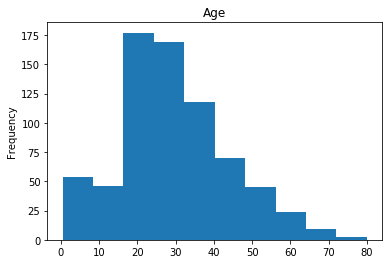

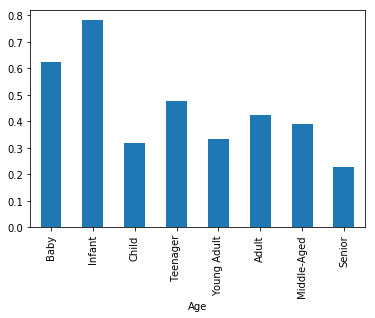

In [7]:
# categorise ages
display(df.Age.describe())
df.Age.plot.hist(title='Age')

def transform_age(df):
    #baby 0-2, infant 3-6, child 7-12
    #teen 13-17, young_adult 18-25, adult 26-40
    #middle-aged 41-60, senior 61+

    df['Age'] = pd.cut(df.Age,
                       [-1,2,6,12,17,25,40,60,200],
                       labels=['Baby','Infant','Child','Teenager','Young Adult','Adult','Middle-Aged','Senior'])
    
    return df

df = transform_age(df)

display(df.Age.value_counts())
display(df.groupby('Title').Age.value_counts())

plt.figure()
mean_survived('Age',df).plot.bar()

In [8]:
# replace missing Embarked values with S - most common port
def fillna_embarked(fill_df):
    fill_df.Embarked = fill_df.Embarked.fillna('S')
    return fill_df

df = fillna_embarked(df)

In [9]:
# replace NaN ages with most common age out of passengers
# with similar features.
def fillna_age(fill_df):
    # passengers with NaN age
    age_null = fill_df[fill_df.Age.isnull()].index
    
    # columns to compare based on equivalence
    cols_equal = ['Pclass','Sex','Title']#['Survived','Pclass','Sex','Title']
    # columns to compare based on both>0 or not
    cols_gr0 = ['SibSp','Parch']
    
    for PassengerId in age_null:
        passenger = fill_df.loc[PassengerId]
        
        # select rows in df (training data) that match features of passenger
        matches = df.copy()

        for col in cols_equal:
            matches = matches[matches[col]==passenger[col]]

        for col in cols_gr0:
            matches = matches[(matches[col]>0)==(passenger[col]>0)]

        # assign most common age in this group to the passenger
        fill_df.loc[PassengerId,'Age']=matches.Age.value_counts().idxmax()
        
    return fill_df

# passengers with NaN age
df = fillna_age(df)    

display(df.Age.value_counts())

Adult          398
Young Adult    212
Middle-Aged    130
Teenager        44
Child           34
Senior          25
Baby            25
Infant          23
Name: Age, dtype: int64

In [10]:
'''
# fill nans in age using a classifier
# seems to give slightly worse final accuracy than approach above

from sklearn.neighbors import KNeighborsClassifier

# which passengers have NaN age
age_null = df.Age.isnull()

# convert to categorical dtype: forces all possible values to have dummy columns later
df_cat = df.apply(lambda x: x.astype('category'))
age_train = df_cat[~age_null]
age_test = df_cat[age_null]

# split to X and y: y is Age column
age_test_X = age_test.drop('Age',axis=1)
age_train_X = age_train.drop('Age',axis=1)
age_train_y = age_train['Age']

# create dummy variables for fitting
age_train_X_dum = pd.get_dummies(age_train_X)
age_test_X_dum = pd.get_dummies(age_test_X)
age_train_y_dum = pd.get_dummies(age_train_y)
age_cols = age_train_y_dum.columns

# fit classifier
knn_age = KNeighborsClassifier(n_neighbors=8)
knn_age.fit(age_train_X_dum,age_train_y_dum)
print('score:',knn_age.score(age_train_X_dum,age_train_y_dum))

def fillna_age(fill_df):
    age_null = fill_df.Age.isnull()
    df_cat = fill_df.apply(lambda x: x.astype('category'))
    X = df_cat[age_null].drop('Age',axis=1)
    X_dum = pd.get_dummies(X)
    
    # predict missing values
    agepred=knn_age.predict(X_dum).argmax(axis=1)

    # convert dummies back to labels
    agepred = age_cols[agepred]

    # fill nan values in original df
    fill_df.loc[age_null,'Age']=agepred
    
    return fill_df

df = fillna_age(df)
''';

In [11]:
# convert all columns to numeric for sklearn
# numeric value is rank of each column category in terms of training survival rate
category_ranks = dict()
for col in df.drop('Survived',axis=1).columns:
    ranks = mean_survived(col,df).sort_values().rank()
    category_ranks[col] = dict((ranks-1).astype(int))
    print(col,':',category_ranks[col])
    print('----------------------')
    
def encode_features(df):
    # get rid of some warning messages for this function
    pd.options.mode.chained_assignment = None
    
    for col in df.drop('Survived',axis=1).columns:
        # check if any values we didn't encounter in training data
        # for now just replace these with mode in training data - look at implementing better method
        is_unknown = ~df[col].isin(category_ranks[col].keys())

        if sum(is_unknown)>0:
            mode_val = df[col].mode()[0]

            print(sum(is_unknown),'UNKNOWN VALUE(S):',
                  'Column =',col,
                  ', Values =',df.loc[is_unknown,col].unique(),
                  ', ReplacedWith = ',mode_val)

            df.loc[is_unknown,col] = mode_val

        # replace values with their numeric equivalents
        df[col].replace(category_ranks[col],inplace=True)
    
    # restore warning messages  
    pd.options.mode.chained_assignment = 'warn'
       
    return df

df = encode_features(df)

Pclass : {3: 0, 2: 1, 1: 2}
----------------------
Sex : {'male': 0, 'female': 1}
----------------------
Age : {'Senior': 0, 'Child': 1, 'Adult': 2, 'Young Adult': 3, 'Middle-Aged': 4, 'Teenager': 5, 'Baby': 6, 'Infant': 7}
----------------------
SibSp : {5: 0, 8: 0, 4: 2, 3: 3, 0: 4, 2: 5, 1: 6}
----------------------
Parch : {4: 0, 6: 0, 5: 2, 0: 3, 2: 4, 1: 5, 3: 6}
----------------------
Cabin : {'T': 0, 'Unknown': 1, 'A': 2, 'G': 3, 'C': 4, 'F': 5, 'B': 6, 'E': 7, 'D': 8}
----------------------
Embarked : {'S': 0, 'Q': 1, 'C': 2}
----------------------
Tshare : {4: 0, 5: 0, 6: 2, 0: 3, 3: 4, 1: 5, 2: 6}
----------------------
Title : {'Rev': 0, 'Mr': 1, 'Military': 2, 'Dr': 3, 'Master': 4, 'Nobility': 5, 'Miss': 6, 'Mrs': 7}
----------------------
Farepp : {'c3_q100': 0, 'c3_q33': 1, 'c3_q66': 2, 'c2_q66': 3, 'c2_q33': 4, 'c2_q100': 5, 'c1_q33': 6, 'c1_q66': 7, 'c1_q100': 8}
----------------------
Faretot : {'c3_q66': 0, 'c3_q33': 1, 'c3_q100': 2, 'c2_q33': 3, 'c1_q33': 4, 'c2_q66

,min,mean,max,std
GradientBoosting,0.784091,0.822641,0.865169,0.023158
SVC,0.775281,0.818147,0.853933,0.022580
DecisionTree,0.786517,0.813716,0.853933,0.022890
AdaBoost,0.733333,0.810432,0.865169,0.037671
LogisticRegression,0.777778,0.810370,0.853933,0.022826
GaussianProcess,0.764045,0.799083,0.831461,0.019272
QuadraticDiscriminant,0.744444,0.798035,0.853933,0.027880
RandomForest,0.730337,0.795738,0.831461,0.030013
KNeighbors,0.741573,0.794501,0.855556,0.040977
GaussianNB,0.688889,0.788123,0.865169,0.058435


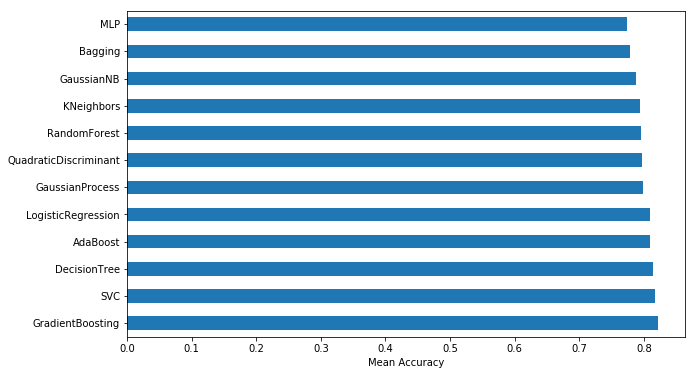

In [25]:
#fit some models
from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


models = {  'DecisionTree':DecisionTreeClassifier(max_depth=3,random_state=RAND_SEED),
            'RandomForest':RandomForestClassifier(random_state=RAND_SEED),
            'Bagging':BaggingClassifier(random_state=RAND_SEED),
            'GradientBoosting':GradientBoostingClassifier(random_state=RAND_SEED),
            'SVC':SVC(random_state=RAND_SEED),
            'LogisticRegression':LogisticRegression(random_state=RAND_SEED),
            'KNeighbors':KNeighborsClassifier(),
            'GaussianNB':GaussianNB(),
            'MLP':MLPClassifier(random_state=RAND_SEED),
            'AdaBoost':AdaBoostClassifier(random_state=RAND_SEED),
            'GaussianProcess':GaussianProcessClassifier(random_state=RAND_SEED),
            'QuadraticDiscriminant':QuadraticDiscriminantAnalysis()
         }

X_train = df.drop('Survived',axis=1)
y_train = df.Survived

cv_scores = dict()
cv_mean = dict()
cv_std = dict()
cv_max = dict()
cv_min = dict()

# fit models with 10-fold cross validation
for label,model in models.items():
    # calculate cv scores for this model
    cv_scores[label] = cross_val_score(model, X_train, y=y_train, 
                                       scoring='accuracy', cv=10)
    
    # calculate basic stats on cv results
    cv_mean[label] = cv_scores[label].mean()
    cv_std[label] = cv_scores[label].std()
    cv_max[label] = cv_scores[label].max()
    cv_min[label] = cv_scores[label].min()


# combine into df
scores_df = pd.DataFrame([cv_min,cv_mean,cv_max,cv_std],
                         index=['min','mean','max','std']).T.sort_values('mean',ascending=False)

#plot/display
ax=plt.figure(figsize=(10,6)).gca()
scores_df['mean'].plot.barh(ax=ax)
plt.xlabel('Mean Accuracy')

display(scores_df)

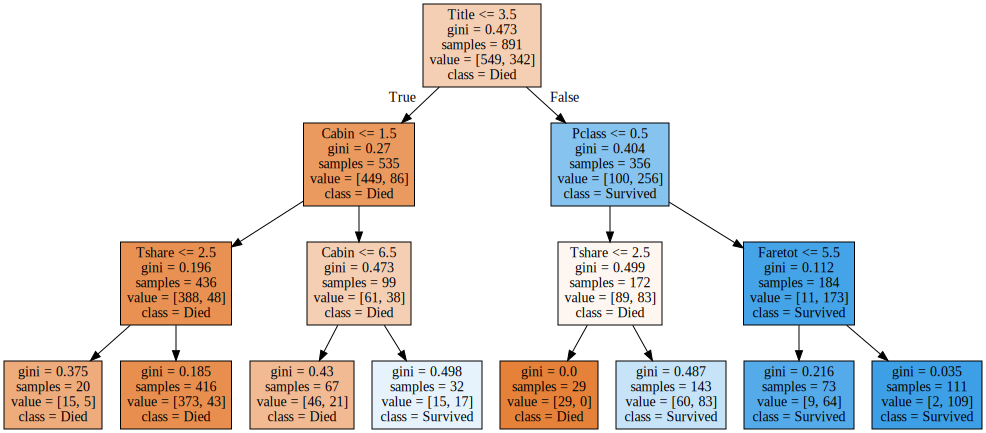

In [26]:
# visualise a decision tree
import graphviz
from sklearn.tree import export_graphviz

export_graphviz(models['DecisionTree'].fit(X_train,y_train),
                out_file='tree.dot',
                feature_names=X_train.columns,
                class_names=['Died','Survived'],
                filled=True)

with open('tree.dot') as f:
    dot_graph=f.read()

graphviz.Source(dot_graph)

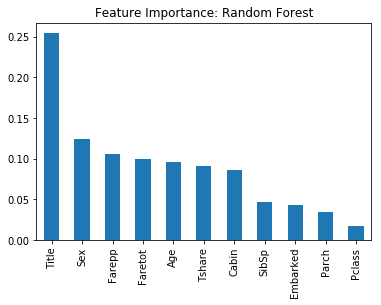

In [28]:
# Feature importance in Random Forest

rndimp=pd.Series(models['RandomForest'].fit(X_train,y_train).feature_importances_,index=X_train.columns)
rndimp.sort_values(ascending=False,inplace=True)
rndimp.plot.bar(title='Feature Importance: Random Forest')

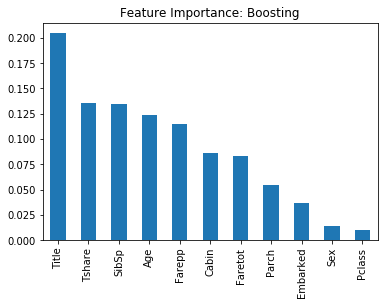

In [29]:
# Feature importance Boosting

booimp=pd.Series(models['GradientBoosting'].fit(X_train,y_train).feature_importances_,index=X_train.columns)
booimp.sort_values(ascending=False,inplace=True)
booimp.plot.bar(title='Feature Importance: Boosting')

In [ ]:
# load test data
df_test = pd.read_csv('test.csv',index_col='PassengerId')
print('==============================')
print('Before data transformation:')
print('==============================')
display(df_test.head())
df_test.info()

# apply feature transformations to test data
transform_funcs = [transform_ticket, 
                   transform_cabin, 
                   transform_name, 
                   transform_fare, 
                   transform_age,
                   fillna_embarked,
                   fillna_age]

for func in transform_funcs:
    df_test = func(df_test)
    
print('==============================')
print('After data transformation:')
print('==============================')
display(df_test.head())
df_test.info()

In [ ]:
# test data has a missing Fare, create function to impute it

# replace NaN ages with most common age out of passengers
# with similar features.
def fillna_fare(fill_df):
    # passengers with NaN age
    fare_null = fill_df[fill_df.Faretot.isnull()].index
    
    # columns to compare based on equivalence
    cols_equal = ['Pclass','Sex','Title','Age','Cabin','Tshare']
    # columns to compare based on both>0 or not
    cols_gr0 = ['SibSp','Parch']
    
    for PassengerId in fare_null:
        passenger = fill_df.loc[PassengerId]
        display(passenger)
        # select rows in df (training data) that match features of passenger
        matches = df.copy()

        for col in cols_equal:
            matches = matches[matches[col]==passenger[col]]
            
        for col in cols_gr0:
            matches = matches[(matches[col]>0)==(passenger[col]>0)]

        # assign most common Fare in this group to the passenger
        fill_df.loc[PassengerId,'Faretot']=matches.Faretot.value_counts().idxmax()
        fill_df.loc[PassengerId,'Farepp']=matches.Farepp.value_counts().idxmax()
        print('Calculated: Faretot =',fill_df.loc[PassengerId,'Faretot'],', Farepp =',fill_df.loc[PassengerId,'Farepp'])

    return fill_df

# passengers with NaN age
df_test = fillna_fare(df_test)
print('\nNew df info:')
df_test.info()

In [ ]:
# encode features of test dataset
X_test = encode_features(df_test)
X_test.head()

In [ ]:
# predict test values
y_test = pd.DataFrame(models['GradientBoosting'].predict(X_test),index=X_test.index)
y_test.columns = ['Survived']
y_test = y_test.sort_index()

display(y_test.Survived.value_counts(normalize=True))

y_test.to_csv('submission.csv')